## Computer Vision - Image classifier

Please find your dataset from the link - https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

#### Points to consider:
    
1. Import Libraries/Dataset
2. Import the required libraries and the dataset (use Google Drive if required).
3. Check the GPU available (recommended- use free GPU provided by Google Colab).
4. Data Visualization and augmentation
    * Plot at least two samples from each class (cats, dogs & panda) of the dataset (use matplotlib/seaborn/any other library).
    * Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. 
    * Print the augmented image and the original image for each class and each augmentation.
5. Bring the train and test data in the required format.
6. Print the shapes of train and test data.
7. Model Building - 
    * Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. 
    * Choose the best number for hidden units and give reasons.
    * Add L2 regularization to all the layers.
    * Add one layer of dropout at the appropriate position and give reasons.
    * Choose the appropriate activation function for all the layers.
    * Print the model summary.
8. Model Compilation - 
    * Compile the model with the appropriate loss function.
    * Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.
    * Use accuracy as a metric.
9. Model Training - 
    * Train the model for an appropriate number of epochs. 
    * Print the train and validation accuracy and loss for each epoch. 
    * Use the appropriate batch size.
    * Plot the loss and accuracy history graphs for both train and validation set. 
    * Print the total time taken for training.
10. Model Evaluation - 
    * Print the final train and validation loss and accuracy. 
    * Print confusion matrix and classification report for the validation dataset. 
    * Analyse and report the best and worst performing class.
    * Print the two most incorrectly classified images for each class in the test dataset.
 

11. Hyperparameter Tuning - 
    * Build two more additional models by changing the following hyperparameters ONE at a time. 
    * Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

* **Dropout**: Change the position and value of dropout layer
* **Regularization**: Train a model without regularization

Write a comparison between each model and give reasons for the difference in results.

In [1]:
# KERAS IMPORTS
from __future__ import print_function
import tensorflow as tff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
# PYTHON IMPORTS
import numpy as np
import pandas as pd
from os import listdir
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

os.getcwd()

In [3]:
# tff.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tff.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
folder_path = './animals/'
for dirname, _, filenames in os.walk(folder_path):
    print(dirname)

./animals/
./animals/cats
./animals/dogs
./animals/panda


### Data Visualization and Augmentation

In [5]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Augmented image')
    plt.imshow(augmented)

In [6]:
datagen_actual = ImageDataGenerator(rescale=1./255)
datagen_morphd = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10, # rotation
                                    width_shift_range=0.2, # horizontal shift
                                    height_shift_range=0.2, # vertical shift
                                    zoom_range=0.2, # zoom
                                    shear_range=0.2, # shear
                                    horizontal_flip=True, # horizontal flip
                                    brightness_range=[0.2,1.2], # brightness 
                                   )
actual = datagen_actual.flow_from_directory('./test', class_mode="categorical", batch_size=128, shuffle=False)
morphed = datagen_morphd.flow_from_directory('./test', class_mode="categorical", batch_size=128, shuffle=False)

Found 6 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [7]:
def getSamplesFromDataGen(actual, morphed):
    x = actual.next() #fetch the first batch
    y = morphed.next()
    a = x[0] # Original Data
    b = y[0] # Augmented Data
    for i in range(0,6):
        visualize(a[i], b[i])

In [ ]:
getSamplesFromDataGen(actual, morphed)

### Loading our Train/Test dataset

change **image_size** to control features and training

    * small image_size will train faster but you lose information in transition.
    * bigger image_size will learn more features but trains slower.

In [ ]:
image_size = 150      # 224 / 128 / 64 

In [15]:
num_classes = 3
batch_size = 16   # lower batch size will get better results
channel = 3
img_height, img_width = (image_size, image_size)


train_data_dir = './animals/'

# Using some data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # rotation
#     width_shift_range=0.2, # horizontal shift
#     height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    shear_range=0.2, # shear
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.4,1.1], # brightness
    validation_split=0.3) # set validation split

In [16]:
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

print(f"Train dataset shape : {train_generator.image_shape}")

Found 2100 images belonging to 3 classes.
Train dataset shape : (150, 150, 3)


In [17]:
validation_generator = datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    subset='validation') # set as validation data

print(f"Test dataset shape : {validation_generator.image_shape}")

Found 900 images belonging to 3 classes.
Test dataset shape : (150, 150, 3)


In [ ]:
# let's display some of the pictures

image, label = train_generator.next()

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
idx = 0
for i in range(4):
    for j in range(4): 
        ax[i][j].axis('off')
        ax[i][j].title.set_text(label[idx])
        ax[i][j].imshow(image[idx], interpolation='none')
        idx = idx + 1

### Defining our Model

In [19]:
model0 = Sequential()

model0.add(Convolution2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, channel)))
model0.add(MaxPooling2D(pool_size=(2, 2)))
model0.add(Convolution2D(64, (3, 3), activation='relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))
# model0.add(Dropout(0.25))

model0.add(Convolution2D(128, (3, 3), padding='same'))
model0.add(Activation('relu'))
model0.add(Convolution2D(128, (3, 3)))
model0.add(Activation('relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))
# model0.add(Dropout(0.2))

model0.add(Convolution2D(256, (3, 3), padding='same'))
model0.add(Activation('relu'))
model0.add(Convolution2D(256, (3, 3)))
model0.add(Activation('relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))
# model0.add(BatchNormalization())
# model0.add(Dropout(0.5))

model0.add(Flatten())
model0.add(Dense(128, activation='relu'))
# model0.add(BatchNormalization())
# model0.add(Dropout(0.3))
model0.add(Dense(128, activation='relu'))
# model0.add(BatchNormalization())
# model0.add(Dropout(0.3))
model0.add(Dense(3, activation='softmax'))

print(model0.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
activation_4 (Activation)    (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)      

In [ ]:
# general CNN architecture 
model1 = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input

# First CONV-ReLU Layer
model1.add(Conv2D(128, (3, 3), padding='same',
                 input_shape= (img_height, img_width, channel)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
# Second CONV-ReLU Layer
model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
# Third CONV-ReLU Layer
model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
# Final fully connected Layer
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model1.summary())

In [9]:
# VGG16 architecture
# Actual image size : (224, 224, 3)

model2 = Sequential()
# First CONV-ReLU Layer
model2.add(Conv2D(input_shape=(img_height, img_width, channel),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# Second CONV-ReLU Layer
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# Max Pooling with Dropout 
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model2.add(Dropout(0.2))
# 3rd set of CONV-ReLU Layers
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# 4th Set of CONV-ReLU Layers
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# Max Pooling with Dropout 
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model2.add(Dropout(0.2))
# 5th Set of CONV-ReLU Layers
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# 6th Set of CONV-ReLU Layers
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# 7th Set of CONV-ReLU Layers
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Flatten())
# First set of FC or Dense Layers
model2.add(Dense(units=4096,activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
# Second set of FC or Dense Layers
model2.add(Dense(units=4096,activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
# Output Layer
model2.add(Dense(units=3, activation="softmax"))

print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [9]:
# %matplotlib inline
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import plot_model
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np

# plot_model(model, to_file='3Animals.png', show_shapes=True, show_layer_names=True)
# img = mpimg.imread('3Animals.png')
# plt.figure(figsize=(100,70))
# imgplot = plt.imshow(img) 

### model0 is used here

In [20]:
model = model0    # SELECT YOUR MODEL object for Training
model_name = "model0_adam_b16_img128_ep30_4.h5"

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]  #  

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=1e-4),  # SGD(learning_rate=1e-3, momentum=0.1),   # RMSprop(learning_rate=1e-5), 
              metrics = ['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    verbose=1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model


# model_name = "<name_your_model>.h5"
model_name = "model0_adam_b16_img128_ep30_4.h5"

img_width, img_height, img_depth = (image_size, image_size, channel)
model = load_model(model_name)


#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

# Create a dictionary of class labels
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
print()
print('Classification Report')
target_names = list(class_labels.values())

print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
print()

accuracy = accuracy_score(validation_generator.classes, y_pred)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("======================================================")


target_names = list(class_labels.values())

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix', fontweight='bold')
fig.colorbar(cax)
ax.set_xticklabels([''] + target_names, weight='bold')
ax.set_yticklabels([''] + target_names, weight='bold')

for i in range(len(target_names)):
    for j in range(len(target_names)):
        ax.text(i, j, cm[j, i], va='center', ha='center', color='w', fontweight='bold', fontsize=14)

plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    if true_label == pred:
        cv2.putText(expanded_image, "MATCH", (400, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,50,50), 3)
    else:
        cv2.putText(expanded_image, "MISMATCH", (400, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,50,50), 3)
    plt.axis('off')
    plt.title(f'Inference', fontweight="bold")
    plt.imshow(cv2.cvtColor(expanded_image, cv2.COLOR_BGR2RGB))
    plt.show()


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class


# dimensions of our images
img_width, img_height = (image_size, image_size)


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 15):
    path = './animals/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
#     images = np.vstack([x])
    classes = np.argmax(model.predict(x), axis=-1) # model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])



### Outcome:
    
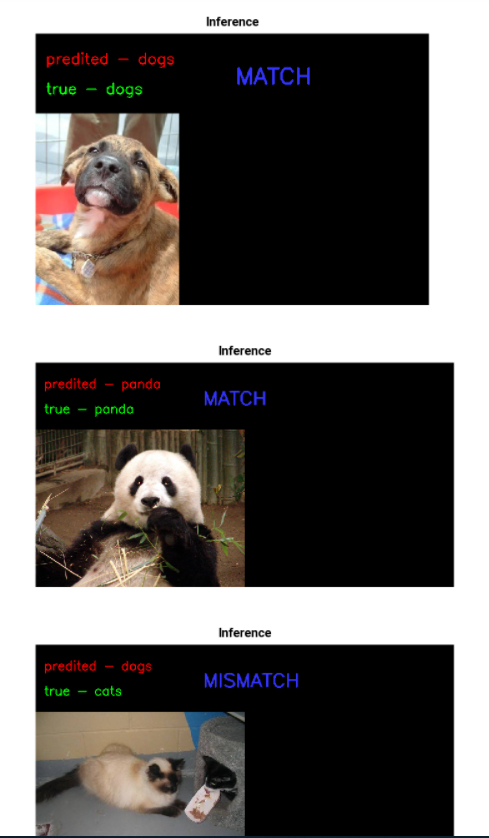

## Model Test Accuracy was around 80%